In [1]:
%load_ext tensorboard

In [3]:
import configuration as config

In [4]:
from os import listdir
import pandas as pd
import numpy as np
from PIL import Image
# import the necessary packages
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import datetime

# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

In [5]:
URL_DRIVE = config.URL_DRIVE
IMAGE_PATH = config.IMAGE_PATH
log_dir = config.LOG_DIR
plot_path = config.PLOT_PATH

output_path = config.OUTPUT_PATH
test_size = config.TEST_SIZE_SPLIT

loss_label = config.LOSS_LABEL
loss_boundingbox = config.LOSS_BOUNDINGBOX
loss_weights = config.LOSS_WEIGHT

init_lr = config.INIT_LR
model_metrics = config.MODEL_METRICS
num_epochs = config.NUM_EPOCHS
batch_size = config.BATCH_SIZE

print_summary = config.PRINT_SUMMARY


In [6]:
# Seleccionamos el dataset que tiene los datos
df = pd.read_csv(f"{URL_DRIVE}df_breve.csv")
df.drop("Unnamed: 0", axis = 1, inplace=True)

df.head(5)

,image,Starting x-coordinate,Starting y-coordinate,Ending x-coordinate,Ending y-coordinate,class label
0,00001063.jpg,235,212,306,255,engine
1,00000259.jpg,363,411,1343,705,wing
2,00000901.jpg,578,86,967,359,fus
3,00001190.jpg,487,218,995,289,wing
4,00001108.png,1,7,1056,298,fus


In [7]:
# Inicializamos la lista de datos, etiquetas y cuadros delimitadores
print("[INFO] Cargando el dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

for i in range(len(df)):
	
	j = df.iloc[i,:]
	# Escalamos el cuadro delimitador a las dimensiones de la imagen de entrada.
	image_url = IMAGE_PATH + j[0]
	image = cv2.imread(image_url)
	(h, w) = image.shape[:2]
	startX = float(j[1]) / w
	startY = float(j[2]) / h
	endX = float(j[3]) / w
	endY = float(j[4]) / h


	image = load_img(image_url, target_size=(224, 224))
	image = img_to_array(image)
  # Cargamos los datos a las listas inicializadas antes
	data.append(image)
	labels.append(j[5])
	bboxes.append((startX, startY, endX, endY))    
	imagePaths.append(image_url)

print("[INFO] Hecho!")

[INFO] Cargando el dataset...
[INFO] Hecho!


In [8]:
# Convertimos las listas en arrays y escalamos la imagen entre [0,1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# one-hot encoding en las etiquetas
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
if len(lb.classes_) == 2:
	labels = to_categorical(labels)


In [9]:

# Particionamos los datos en entrenamiento y validación 
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=test_size, random_state=42)
 
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# Vamos a guardar el nombre de los ficheros que vamos a usar en el conjunto de v
# validación

print("[INFO] saving testing image paths...")
f = open(f"{output_path}test_paths.txt", "w")
f.write("\n".join(testPaths))
f.close()

# Cargamos el modelo VGG con los pesos del entrenamiento en imagenet y sin las 
# últimas capas
vgg = VGG16(weights = "imagenet", include_top = False, 
            input_tensor = Input(shape=(224,224,3)))
# Congelamos los pesos de modo que no se "entrenen" durante el entrenamiento
vgg.trainable = False

if print_summary:
  vgg.summary()

[INFO] saving testing image paths...
58900480/58889256 [==============================] - 3s 0us/step


In [10]:
# Vamos a añadir más capas
flatten = vgg.output
flatten = Flatten()(flatten)

bboxHead = Dense(32, activation="relu")(flatten)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
 
softmaxHead = Dense(264, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)

#Juntamos todo: Modelo que acepta como input una imagen y que tiene como salida
# las etiquetas y los cuadros delimitadores
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

# Definir un diccionario para establecer las funciones de pérdida 
losses = {
	"class_label": loss_label,
	"bounding_box": loss_boundingbox,
}
# Diccionario para los pesos. Mismo para los dos
lossWeights = {
	"class_label": loss_weights,
	"bounding_box": loss_weights
}
# Compilamos el modelo
opt = Adam(lr=init_lr)#config.INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=model_metrics, loss_weights=lossWeights)

# Diccionario para nuestras salidas de entrenamiento
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# Diccionario para nuestras salidas de validación
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

if print_summary:
  print(model.summary())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
# Entrenamiento
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data = (testImages, testTargets),
	batch_size = batch_size,
	epochs = num_epochs,
	verbose = 1,
	callbacks = [tensorboard_callback])

# Serializamos el modelo en disco
print("[INFO] saving object detector model...")
model.save(f"{output_path}detector.h5", save_format = "h5")
# Serializamos el binarizador de etiquetas en disco
print("[INFO] saving label binarizer...")
f = open(f"{output_path}lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/25
14/14 [==============================] - 37s 1s/step - loss: 1.8138 - bounding_box_loss: 0.0492 - class_label_loss: 1.7646 - bounding_box_accuracy: 0.4811 - class_label_accuracy: 0.2571 - val_loss: 1.4944 - val_bounding_box_loss: 0.0425 - val_class_label_loss: 1.4519 - val_bounding_box_accuracy: 0.6509 - val_class_label_accuracy: 0.2925
Epoch 2/25
14/14 [==============================] - 9s 655ms/step - loss: 1.3547 - bounding_box_loss: 0.0355 - class_label_loss: 1.3192 - bounding_box_accuracy: 0.5896 - class_label_accuracy: 0.4127 - val_loss: 1.5400 - val_bounding_box_loss: 0.0413 - val_class_label_loss: 1.4986 - val_bounding_box_accuracy: 0.6038 - val_class_label_accuracy: 0.3679
Epoch 3/25
14/14 [==============================] - 8s 633ms/step - loss: 1.1991 - bounding_box_loss: 0.0305 - class_label_loss: 1.1686 - bounding_box_accuracy: 0.6651 - class_label_accuracy: 0.4929 - val_loss: 1.4815 - val_bounding_box_loss: 0.0413 - val_class_label_loss:

In [ ]:
#%tensorboard --logdir log_dir

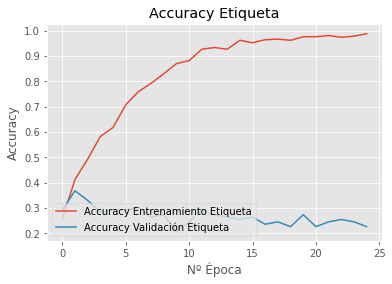

In [15]:
# Graficamos la pérdida total, de la etiqueta y del cuadro delimitador
lossNames =  ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, num_epochs)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# Iteramos para las diferentes pérdidas
for (i, l) in enumerate(lossNames):
	# Pérdida para entrenamiento y validación
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Nº Époco")
	ax[i].set_ylabel("Pérdida")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# Guardamos 
plt.tight_layout()
plotPath = os.path.sep.join([plot_path, "losses.png"])
plt.savefig(plotPath)
plt.close()

# Figura para accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="Accuracy Entrenamiento Etiqueta")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="Accuracy Validación Etiqueta")
plt.title("Accuracy Etiqueta")
plt.xlabel("Nº Época")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([plot_path, "accs.png"])
plt.savefig(plotPath)